In [19]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
import xarray as xr
#import pandas as pd
#import matplotlib as mpl
#import openpyxl
#from mpl_toolkits.basemap import Basemap
#import matplotlib.pyplot as plt
import numpy as np
#from math import cos, radians
import datetime as dt
import os
from os.path import exists


dir_cmc='F:/data/sst/cmc/CMC0.2deg/v2/'
dir_cmc_clim='F:/data/sst/cmc/CMC0.2deg/v2/climatology/'
dir_clim='F:/data/sat_data/oscar/L4/oscar_third_deg/climatology/'
dir_data = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/'
dir_figs = 'F:/data/eddy/figures/'
dir_timeseries = 'F:/data/eddy/timeseries_data/'

boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2']
boxes_lon_min = [-160,-130,-125,-130,-148]
boxes_lon_max = [-170,-140,-135,-140,-158]
boxes_lat_min = [41,46,35,52,52]
boxes_lat_max = [46,51,40,57,57]
boxes_lon_min_180 = boxes_lon_min[:]
boxes_lon_max_180 = boxes_lon_max[:]
for i in range(0,5):
    boxes_lon_min[i] += 360
    boxes_lon_max[i] += 360

#trying to get into xarray properly
location_values = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2']
data = [-160,-130,-125,-130,-148]
lon1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [-170,-140,-135,-140,-158]
lon2 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [41,46,35,52,52]
lat1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [46,51,40,57,57]
lat2 = xr.DataArray(data, coords=[location_values], dims=['location'])
boxes = xr.Dataset({'lon_min':lon1,'lon_max':lon2,'lat_min':lat1,'lat_max':lat2})
#boxes2 = xr.Dataset({'lon_min': (('location'), lon1),
#                 'lon_max': (('location'), lon2)},
#                { 'location': location_values})


def get_climatology(data_type):
    if data_type=='oscar':
        filename = 'F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc'        
    if data_type=='sss':
        filename = 'F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_monthly_1993_2016_mercatorglorys12v1_gl12_mean.nc'
    if data_type=='sst':
        filename = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = 'F:/data/sat_data/ccmp/v02.0/monthly_climatology_ccmp_V02.0_L3.5_RSS.nc'
    return filename

def get_data(data_type,lyr):
    if data_type == 'oscar':
        dir_data = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
        filename = dir_data + str(lyr) + 'monthly_data_oscar.nc'
    if data_type=='sss':
        dir_data='F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/'
        fname_tem=str(lyr) + '/'+ 'year_subset_mercatorglorys12v1_gl12_mean_' + str(lyr) + '.nc'
        filename = dir_data + fname_tem
    if data_type=='sst':
        dir_data = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/' 
        filename = dir_data + str(lyr) + 'monthly_average_' + str(lyr) + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        dir_data='F:/data/sat_data/ccmp/v02.0/'
        filename = dir_data + str(lyr) + 'monthly_average_ccmp_V02.0_L3.5_RSS.nc'
    return filename


In [20]:
i=0
lyr=2015
dtype='ccmp'
#dtype='oscar'
#dtype='sst'
#dtype='sss'
filename = get_climatology(dtype)
print(filename)
ds=xr.open_dataset(filename)
print(ds)
if dtype=='ccmp':
    ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
elif dtype=='oscar':
    ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
else:
    ds_subset = ds.sel(lon=slice(boxes.lon_max[i],boxes.lon_min[i]),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
ds.close()       
print(ds_subset)


F:/data/sat_data/ccmp/v02.0/monthly_climatology_ccmp_V02.0_L3.5_RSS.nc
<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, month: 12)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd     (month, lat, lon) float32 ...
    vwnd     (month, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lat: 20, lon: 40, month: 12)
Coordinates:
  * lon      (lon) float32 190.125 190.375 190.625 ... 199.375 199.625 199.875
  * lat      (lat) float32 41.125 41.375 41.625 41.875 ... 45.375 45.625 45.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd     (month, lat, lon) float32 ...
    vwnd     (month, lat, lon) float32 ...


In [21]:
dtype = 'oscar'
filename = get_climatology(dtype)
ds = xr.open_dataset(filename)
print(ds)
if dtype=='ccmp':
    ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
elif dtype=='oscar':
    ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
else:
    ds_subset = ds.sel(lon=slice(boxes.lon_max[i],boxes.lon_min[i]),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
ds.close()       
ds_mean_clim = ds_subset.mean('lat').mean('lon')   
ds_mean_clim

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 481, lon: 1201, month: 12)
Coordinates:
  * depth    (depth) float32 15.0
  * lat      (lat) float64 80.0 79.67 79.33 79.0 ... -79.0 -79.33 -79.67 -80.0
  * lon      (lon) float64 20.0 20.33 20.67 21.0 ... 419.0 419.3 419.7 420.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u        (month, depth, lat, lon) float64 ...
    v        (month, depth, lat, lon) float64 ...


<xarray.Dataset>
Dimensions:  (depth: 1, month: 12)
Coordinates:
  * depth    (depth) float32 15.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u        (month, depth) float64 0.03773 0.04143 0.03425 ... 0.03791 0.04664
    v        (month, depth) float64 -0.006465 -0.01019 ... -0.013 -0.01704

In [ ]:
ds.lon[0:10]

In [55]:
#make oscar timeseries
#for ibox in range(0,2): #5):
#dtype='ccmp'
#dtype='oscar'
#dtype='sst'
dtype='sss'

for i in range(0,5):
    for lyr in range(2000,2018):
        filename = get_data(dtype,lyr)
        if os.path.exists(filename):      
            ds=xr.open_dataset(filename)
            if dtype=='ccmp':
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            elif dtype=='oscar':
                ds = ds.drop('year')
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
            else:
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i],boxes.lon_min[i]),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            ds.close()       
            ds_mean = ds_subset.mean('lat').mean('lon')   
#get climatology
            filename = get_climatology(dtype)
            ds = xr.open_dataset(filename)
            if dtype=='ccmp':
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            elif dtype=='oscar':
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i]+360,boxes.lon_min[i]+360),lat=slice(boxes.lat_max[i],boxes.lat_min[i])) 
            else:
                ds_subset = ds.sel(lon=slice(boxes.lon_max[i],boxes.lon_min[i]),lat=slice(boxes.lat_min[i],boxes.lat_max[i])) 
            ds.close()       
            ds_mean_clim = ds_subset.mean('lat').mean('lon')   
            
            ds_diff = ds_mean.groupby('time.month') - ds_mean_clim
            if lyr==2000:
                ds_box = ds_mean
                ds_box_clim = ds_diff
            else:
                ds_box = xr.concat([ds_box,ds_mean],dim='time')
                ds_box_clim = xr.concat([ds_box_clim,ds_diff],dim='time')
        #print(box)
    if i==0:
        ds_newbox = ds_box
        ds_newbox_clim = ds_box_clim
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        ds_newbox_clim = xr.concat([ds_newbox_clim,ds_box_clim],dim='box')
        #print(ds_newbox.box)
filename_out = dir_timeseries + dtype + 'data.nc'
ds_newbox.to_netcdf(filename_out)
filename_out_clim = dir_timeseries + dtype + 'data_minus_clim.nc'
ds_newbox_clim.to_netcdf(filename_out_clim)
print('out!')
#        ds_subset['tot_vel']=(ds_subset.u**2+ds_subset.v**2)**.5       
#        ds_subset['tot_vel_var']=ds_subset.tot_vel**2      
#        ds_subset['u_sq']=ds_subset.u**2       
#        ds_subset['v_sq']=ds_subset.v**2      
#        ds_mean = ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    


out!


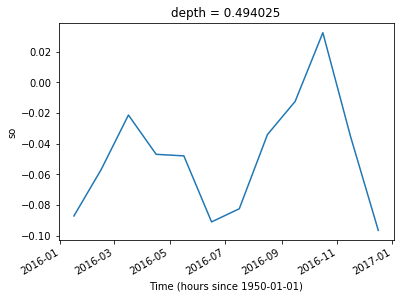

In [45]:
#ds_mean.so.plot()
#ds_diff = ds_mean.groupby('time.month') - ds_mean_clim
#ds_diff.so.plot()
#ds_mean_clim.so.plot()

In [9]:
#print(ds_diff)
#print(ds_mean)
print(ds_mean_clim)

toy_weather_climatology = ds.groupby('time.month').mean('time')

toy_weather_anomalies = ds.groupby('time.month') - toy_weather_climatology


<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
    depth    float32 ...
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    so       (month) float64 33.2 33.25 33.27 33.28 ... 33.09 33.1 33.11 33.12


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
print(toy_weather_climatology)
print(toy_weather_anomalies)

<xarray.Dataset>
Dimensions:  (lat: 901, lon: 1800, month: 12)
Coordinates:
    depth    float32 0.494025
  * lat      (lat) float64 -90.0 -89.8 -89.6 -89.4 -89.2 ... 89.4 89.6 89.8 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.6 -179.4 ... 179.4 179.6 179.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mlotst   (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    zos      (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    bottomT  (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    sithick  (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    siconc   (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    usi      (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    vsi      (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    thetao   (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    so       (month, lat, lon) flo

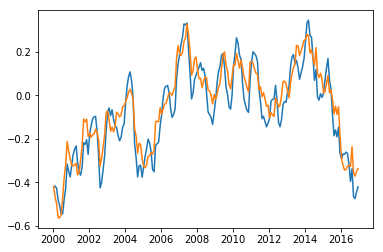

In [52]:
import matplotlib.pyplot as plt
plt.plot(ds_newbox.time[:],ds_newbox.so[0,:]-33.2)
plt.plot(ds_newbox.time[:],ds_newbox_clim.so[0,:])
#plt.plot(ds_newbox.time[:],ds_newbox_clim.so[0,:,0])

In [ ]:
ds_newbox.time[0:15]

In [ ]:
filename_oscar_out = 'F:/data/eddy/bifurcation_ms/oscar_boxes_timeseries.nc'
ds_oscar = xr.open_dataset(filename_oscar_out)
ds_oscar.close()
filename_TS_out = 'F:/data/eddy/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.close()

In [ ]:
ds_cmc.analysed_sst

In [ ]:
min(ds_cmc.time[:])

In [ ]:
import matplotlib.pyplot as plt
#        fig,ax = plt.subplots(1)
plt.figure(figsize=(6, 8))
for i in range(0,5):
    plt.subplot(5, 1, i+1)
    plt.plot(ds_oscar.time[:],ds_oscar.tot_vel[i,:,0])
    #plt.text(2012,0.1,str(boxes_names[i]), fontsize=12)
    plt.ylim([0.03,0.15])
#    if i<4:
#        plt.set_xticklabels([])
    if i==4:
        plt.xlabel('Date')
    if i==2:
        plt.ylabel('Total Current (cm s$^{-1}$)')
    #plt.plot(ds_cmc.time[:],ds_cmc.analysed_sst[i,:]-273.15,'r')
fig_fname=dir_figs+"boxes_oscar.png"
#fig_fname=dir_figs+"boxes_sst.png"
plt.savefig(fig_fname, transparent=False, format='png')
plt.show()
print(fig_fname)

In [ ]:
#filename_oscar_clim = dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc'
filename_TS_out = 'F:/data/eddy/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
#make cmc timeseries
#for ibox in range(0,2): #5):
inc=-1
for box in boxes_names:
    inc+=1 
    for lyr in range(2000,2017):
        syr=str(lyr).zfill(4)
        fname_tem='monthly_average_' + syr + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
        cmc_filename_out = dir_cmc + syr + fname_tem
        ds=xr.open_dataset(cmc_filename_out)
        ds_subset = ds.sel(lon=slice(boxes_lon_max_180[inc],boxes_lon_min_180[inc]),lat=slice(boxes_lat_min[inc],boxes_lat_max[inc])) 
        ds.close()
 #       ds_mean = ds_subset #ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    
        ds_mean = ds_subset.mean('lat').mean('lon')
        if lyr==2000:
            ds_box = ds_mean
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='time')
        #print(box)
    if box=='NPC':
        ds_newbox = ds_box
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        #print(ds_newbox.box)
ds_newbox.to_netcdf(filename_TS_out)

In [ ]:
#ds
#ds_subset.analysed_sst[0,:]
#boxes_lon_max_180
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.analysed_sst